In [1]:
import pandas as pd

In [2]:
!pip install Lifetimes

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns

from sklearn.metrics import mean_absolute_percentage_error

from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import \
    calibration_and_holdout_data, \
    summary_data_from_transaction_data, \
    calculate_alive_path
from lifetimes.plotting import \
    plot_frequency_recency_matrix, \
    plot_probability_alive_matrix, \
    plot_period_transactions, \
    plot_history_alive, \
    plot_cumulative_transactions, \
    plot_calibration_purchases_vs_holdout_purchases, \
    plot_transaction_rate_heterogeneity, \
    plot_dropout_rate_heterogeneity

In [5]:
transactions = pd.read_csv('transactions_train.csv')

In [6]:
articles = pd.read_csv('articles.csv')

In [7]:
clusters = pd.read_csv('clusters_4.csv')

In [8]:
view = pd.merge(left=transactions, right=articles, how='left', left_on='article_id', right_on='article_id')

In [9]:
view.head(5)

,t_dat,customer_id,article_id,price,sales_channel_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,663713,Atlanta Push Body Harlow,283,Underwear body,Underwear,...,Expressive Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up body with underwired, moulded, pa..."
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,541518,Rae Push (Melbourne) 2p,306,Bra,Underwear,...,Casual Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace push-up bras with underwired, moulded, pa..."
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2,505221,Inca Jumper,252,Sweater,Garment Upper body,...,Tops Knitwear DS,D,Divided,2,Divided,58,Divided Selected,1003,Knitwear,Jumper in rib-knit cotton with hard-worn detai...
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2,685687,W YODA KNIT OL OFFER,252,Sweater,Garment Upper body,...,Campaigns,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1023,Special Offers,V-neck knitted jumper with long sleeves and ri...
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2,685687,W YODA KNIT OL OFFER,252,Sweater,Garment Upper body,...,Campaigns,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1023,Special Offers,V-neck knitted jumper with long sleeves and ri...


In [10]:
view1 = view.groupby(["product_type_name", "department_name"]).agg({'price': 'mean'}).reset_index()

In [11]:
view1.head(5)

,product_type_name,department_name,price
0,Accessories set,Baby Toys/Acc,0.021262
1,Accessories set,Boys Small Acc & Bags,0.009729
2,Accessories set,Kids Girl Big Acc,0.022017
3,Alice band,Girls Small Acc/Bags,0.008016
4,Alice band,Hair Accessories,0.010388


In [12]:
# Baby toys in H&M US Website --> 20+ USD

In [14]:
df = transactions.copy()

In [15]:
# Assumption scale by 1000
df['price'] = df['price'] * 1000

In [16]:
df.describe()

,article_id,price,sales_channel_id
count,3.178832e+07,3.178832e+07,3.178832e+07
mean,6.962272e+08,2.782927e+01,1.704028e+00
std,1.334480e+08,1.918113e+01,4.564786e-01
min,1.087750e+08,1.694915e-02,1.000000e+00
25%,6.328030e+08,1.581356e+01,1.000000e+00
50%,7.145820e+08,2.540678e+01,2.000000e+00
75%,7.865240e+08,3.388136e+01,2.000000e+00
max,9.562170e+08,5.915254e+02,2.000000e+00


In [17]:
# Filter by customers avil in segments
clusters.head(5)

,customer_id,cluster
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,Champions
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,Champions
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,Champions
3,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,Champions
4,000097d91384a0c14893c09ed047a963c4fc6a5c021044...,Unprofitable


In [21]:
df = df[df['customer_id'].isin(clusters['customer_id'])].reset_index(drop=True)

In [22]:
df.drop(["sales_channel_id"], axis = 1, inplace=True)

In [23]:
data_grp = df.groupby(["t_dat", "customer_id"]).agg({'article_id':'count', 'price': 'sum'}).reset_index()

In [24]:
data_grp.describe()

,article_id,price
count,54018.000000,54018.000000
mean,2.850217,77.415860
std,2.546998,81.905230
min,1.000000,0.847458
25%,1.000000,32.169492
50%,2.000000,50.830508
75%,4.000000,94.847458
max,42.000000,4558.966102


CLV

4.1 Definitions
* Recency: the number of time periods between a customer’s first and last (latest) transactions
* Frequency: the number of time periods, after the initial purchase, when the customer buys again
* Monetary Value: the average value of the customer’s transactions (revenues or profit per transaction)

Additionally,
* Customer age T: the number of time periods since the customer’s first purchase

In [25]:
data_grp['t_dat'] = pd.to_datetime(data_grp['t_dat'])

In [26]:
# train/test split (calibration/holdout)
t_holdout = 240                                         # days to reserve for holdout period

max_date = data_grp["t_dat"].max()                     # end date of observations
print("end of observations:", max_date)

max_cal_date = max_date - timedelta(days=t_holdout)     # end date of chosen calibration period
print("end of calibration period:", max_cal_date)

df_ch = calibration_and_holdout_data(
        transactions = data_grp, 
        customer_id_col = "customer_id", 
        datetime_col = "t_dat",
        monetary_value_col = "price", 
        calibration_period_end = max_cal_date, 
        observation_period_end = max_date, 
        freq = "D")  

print("customer behavior in calibration and holdout periods")
pd.options.display.float_format = '{:,.0f}'.format
df_ch

end of observations: 2020-09-22 00:00:00
end of calibration period: 2020-01-26 00:00:00
customer behavior in calibration and holdout periods


,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customer_id,,,,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,7,336,395,56,2,72,240
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,2,162,493,32,4,140,240
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,3,362,471,49,2,128,240
0000945f66de1a11d9447609b8b41b1bc987ba185a5496ae8831e8493afa24ff,0,0,72,0,1,42,240
000097d91384a0c14893c09ed047a963c4fc6a5c021044eec603b323e8c82d1d,0,0,449,0,0,0,240
...,...,...,...,...,...,...,...
058541084e0d4cab8a70b3e6c1749ff59bdef783fb667f72c6b26ae0441c620f,1,1,243,64,0,0,240
05854b82c895afd025f959f3bece77106ef93b1d24c6c991c596ac5fd94f1b3f,2,342,492,148,0,0,240
058551aae22c37412da14b7982ac1327ec5e85ddf6413ee96747e45729bfc475,2,161,177,59,1,68,240


5.1 BG/NBD Concept
In non-contractual business settings, the purchase behavior of customers does not follow a deterministic trend. Both demand levels and churn rates are random variables. A distributional model like BG/NBD describes the random processes that influence the customer behavior, individually and in aggregate.
The method relies on four distributional assumptions to model the uncertainties:
* The number of orders a customer will place in a time period follows a Poisson distribution with transaction rate lambda. This Poisson count distribution is equivalent to the assumption that the time between transactions follows an exponential distribution with the same transaction rate lambda.
* The demand varies independently between customers: heterogeneity in lambda. The variation in lambda is a random variable that follows a Gamma distribution with shape parameter r and scale alpha.
* After any purchase, a customer may become inactive with probability p and turns away from the business. The churn risk follows a Geometric distribution.
* The churn risk varies independently between customers: heterogeneity in p. The variation of the churn or dropout probability p is a random variable that follows a Beta distribution.

In [27]:
# training: BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=1e-06)
bgf.fit(
        frequency = df_ch["frequency_cal"], 
        recency = df_ch["recency_cal"], 
        T = df_ch["T_cal"],   
        weights = None,  
        verbose = True,   
        tol = 1e-06)

Optimization terminated successfully.
         Current function value: -1.299096
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29


<lifetimes.BetaGeoFitter: fitted with 10556 subjects, a: 1.18, alpha: 83.53, b: 16.27, r: 0.75>

<Figure size 864x864 with 0 Axes>

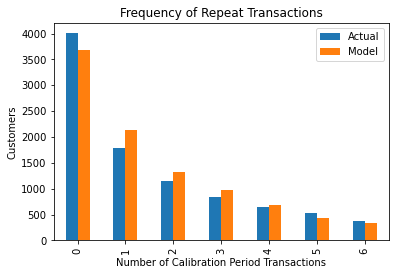

In [28]:
# training: does the model reflect the actual data closely enough?

# frequency of repeat transactions: predicted vs actual
fig = plt.figure(figsize=(12, 12))
plot_period_transactions(bgf);

<Figure size 504x504 with 0 Axes>

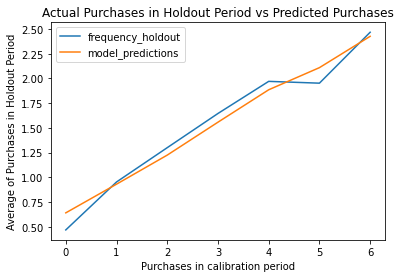

In [29]:
# testing: predicted vs actual purchases in holdout period
fig = plt.figure(figsize=(7, 7)) 
plot_calibration_purchases_vs_holdout_purchases(bgf, df_ch);

In [30]:
# determine recency, frequency, T, monetary value for each customer
df_rft = summary_data_from_transaction_data(
    transactions = data_grp, 
    customer_id_col = "customer_id", 
    datetime_col = "t_dat", 
    monetary_value_col = "price", 
    observation_period_end = max_date, 
    freq = "D")

pd.options.display.float_format = '{:,.0f}'.format
df_rft

,frequency,recency,T,monetary_value
customer_id,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,9,618,635,60
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,6,726,733,104
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,5,670,711,80
0000945f66de1a11d9447609b8b41b1bc987ba185a5496ae8831e8493afa24ff,1,249,312,42
000097d91384a0c14893c09ed047a963c4fc6a5c021044eec603b323e8c82d1d,0,0,689,0
...,...,...,...,...
058551aae22c37412da14b7982ac1327ec5e85ddf6413ee96747e45729bfc475,3,276,417,62
0585761bf583cc8468a107690940cfc34e685cb75c6b0ca992ba865d912ee8a3,7,594,642,178
0585981d85cc02082b3f591342a90fab8144c398319ffa45ee72d6e6a598247e,1,587,641,110


In [31]:
# BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=1e-06)
bgf.fit(
        frequency = df_rft["frequency"], 
        recency = df_rft["recency"], 
        T = df_rft["T"],   
        weights = None,  
        verbose = True,   
        tol = 1e-06)
pd.options.display.float_format = '{:,.3f}'.format
bgf.summary

Optimization terminated successfully.
         Current function value: -2.732061
         Iterations: 27
         Function evaluations: 28
         Gradient evaluations: 28


,coef,se(coef),lower 95% bound,upper 95% bound
r,0.667,0.013,0.642,0.691
alpha,81.707,2.007,77.772,85.641
a,0.597,0.093,0.415,0.779
b,8.455,1.647,5.227,11.684


38


<Figure size 864x864 with 0 Axes>

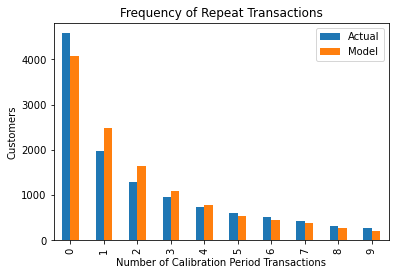

In [32]:
#axis length
max_freq = int(df_rft["frequency"].max())  #quantile(0.95))          
max_T = int(df_rft["T"].max())                         
max_rec = int(df_rft["recency"].max())  
print(max_freq)


# frequency of repeat transactions: predicted vs actual
fig = plt.figure(figsize=(12, 12))
plot_period_transactions(
            model = bgf,  
            max_frequency = 10);

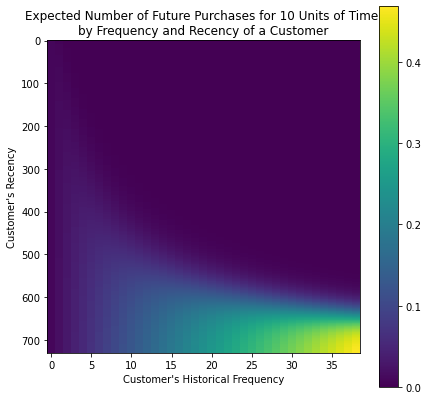

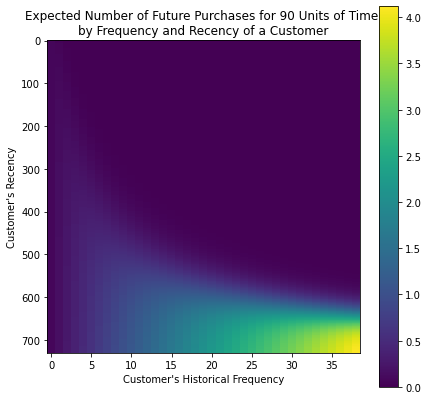

In [33]:

# helper function: plot expected number of future purchases a customer with 
#    frequency f and recency r will make in forecast period

def plot_freq_rec(t):
    fig = plt.figure(figsize=(7, 7)) 
    plot_frequency_recency_matrix(
            model = bgf,   
            T = t,  
            max_frequency = max_freq,  
            max_recency = max_rec);
            
            
# call plotter function for different forecast periods:
tFC = [10, 90]
_ = [plot_freq_rec(t) for t in tFC]

In [34]:
# helper function: predict each customer's purchases over next t days
def predict_purch(df, t):
        df["predict_purch_" + str(t)] = \
                bgf.predict(
                    t, 
                    df["frequency"], 
                    df["recency"], 
                    df["T"])
                    
                    
# call helper function: predict each customer's purchases over multiple time periods
t_FC = [10, 30, 60, 90]
_ = [predict_purch(df_rft, t) for t in t_FC]
pd.options.display.float_format = '{:,.1f}'.format
print("predicted number of purchases for each customer over next t days:")
df_rft

predicted number of purchases for each customer over next t days:


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90
customer_id,,,,,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,9.0,618.0,635.0,59.9,0.1,0.4,0.8,1.1
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,6.0,726.0,733.0,103.9,0.1,0.2,0.5,0.7
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,5.0,670.0,711.0,80.4,0.1,0.2,0.4,0.6
0000945f66de1a11d9447609b8b41b1bc987ba185a5496ae8831e8493afa24ff,1.0,249.0,312.0,42.3,0.0,0.1,0.2,0.3
000097d91384a0c14893c09ed047a963c4fc6a5c021044eec603b323e8c82d1d,0.0,0.0,689.0,0.0,0.0,0.0,0.1,0.1
...,...,...,...,...,...,...,...,...
058551aae22c37412da14b7982ac1327ec5e85ddf6413ee96747e45729bfc475,3.0,276.0,417.0,62.1,0.1,0.2,0.4,0.5
0585761bf583cc8468a107690940cfc34e685cb75c6b0ca992ba865d912ee8a3,7.0,594.0,642.0,178.4,0.1,0.3,0.6,0.9
0585981d85cc02082b3f591342a90fab8144c398319ffa45ee72d6e6a598247e,1.0,587.0,641.0,110.1,0.0,0.1,0.1,0.2


In [35]:

# top 10 customers over next 30 days
print("top 10 customers, by their predicted purchases over next 30 days")
df_rft.sort_values(by="predict_purch_30", ascending=False).head(10)

top 10 customers, by their predicted purchases over next 30 days


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90
customer_id,,,,,,,,
04d03f4289c5ab3ec0572d179988c7ca5ae8012ea35972db7c22210abc532748,10.0,16.0,18.0,101.9,1.0,2.9,5.6,8.1
0574f1efcf6c15c006d5c325190a2d8c435917b2c5f0c73bcebfa423e359d101,10.0,81.0,82.0,48.9,0.6,1.8,3.5,5.2
023ced97d0c6a7aab27dd4d3b6a3258246c72258bc33950ecb9e802bd507f334,8.0,51.0,55.0,68.0,0.6,1.7,3.4,4.9
038cadb73ef70964291fd5781d67050b6c19a02000cd256e058d9de2a55532bc,23.0,336.0,339.0,62.7,0.5,1.6,3.2,4.7
026a8ae78b4352cfddf38a03c072c72f11149bf65dfdd50bc474d6c5b7c46db8,18.0,249.0,254.0,49.4,0.5,1.6,3.1,4.6
0471be61e88d51ee4ba69b2f0c442fba753834f0355eb651fdf8e43680f0db0d,21.0,314.0,325.0,80.2,0.5,1.5,3.0,4.4
0088ac2be49fe6c164930781e72f1330aaa1dd85e67e468947b22dd4bb111bc4,9.0,94.0,98.0,68.9,0.5,1.5,2.9,4.3
011962907f91442ba85ee8c16a5e404398ceb3588b6f592322a4bf858cd92265,19.0,295.0,296.0,32.5,0.5,1.5,3.0,4.4
007ea745333169a47e761ef291dee7839954fa37652781e8df4a63f8e885fe7f,9.0,93.0,98.0,35.0,0.5,1.5,2.9,4.3


CLV

In [36]:
# select customers with monetary value > 0
df_rftv = df_rft[df_rft["monetary_value"] > 0]
pd.options.display.float_format = '{:,.2f}'.format
df_rftv.describe()

,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90
count,"8,350.00","8,350.00","8,350.00","8,350.00","8,350.00","8,350.00","8,350.00","8,350.00"
mean,4.92,357.87,541.14,80.52,0.07,0.22,0.44,0.65
std,4.39,223.62,186.35,65.40,0.07,0.19,0.38,0.57
min,1.00,1.00,6.00,2.69,0.00,0.00,0.00,0.00
25%,2.00,152.00,440.00,42.36,0.03,0.08,0.16,0.23
50%,3.00,371.00,607.00,63.51,0.06,0.17,0.33,0.49
75%,7.00,562.00,695.00,97.12,0.10,0.31,0.62,0.92
max,38.00,730.00,733.00,"1,891.06",1.01,2.92,5.59,8.05


In [37]:
# Gamma-Gamma model requires a Pearson correlation close to 0 
# between purchase frequency and monetary value

corr_matrix = df_rftv[["monetary_value", "frequency"]].corr()
corr = corr_matrix.iloc[1,0]
print("Pearson correlation: %.3f" % corr)

Pearson correlation: -0.130


In [38]:
# fitting the Gamma-Gamma model
ggf = GammaGammaFitter(penalizer_coef = 1e-06)
ggf.fit(
        frequency = df_rftv["frequency"],
        monetary_value = df_rftv["monetary_value"],  
        weights = None,   
        verbose = True,  
        tol = 1e-06,  
        q_constraint = True)
pd.options.display.float_format = '{:,.3f}'.format
ggf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,3.412,0.122,3.172,3.651
q,4.185,0.089,4.011,4.359
v,74.669,3.783,67.254,82.083


In [39]:

# estimate the average transaction value of each customer, based on frequency and monetary value
exp_avg_rev = ggf.conditional_expected_average_profit(
        df_rftv["frequency"],
        df_rftv["monetary_value"])

df_rftv["exp_avg_rev"] = exp_avg_rev
df_rftv["avg_rev"] = df_rftv["monetary_value"]
df_rftv["error_rev"] = df_rftv["exp_avg_rev"] - df_rftv["avg_rev"]

mape = mean_absolute_percentage_error(exp_avg_rev, df_rftv["monetary_value"])
print("MAPE of predicted revenues:", f'{mape:.2f}')

pd.options.display.float_format = '{:,.3f}'.format
df_rftv.head()

MAPE of predicted revenues: 0.15


,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,exp_avg_rev,avg_rev,error_rev
customer_id,,,,,,,,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,9.000,618.000,635.000,59.874,0.129,0.384,0.763,1.136,61.763,59.874,1.889
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,6.000,726.000,733.000,103.910,0.078,0.233,0.464,0.692,100.686,103.910,-3.223
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,5.000,670.000,711.000,80.386,0.067,0.200,0.399,0.595,80.321,80.386,-0.065
0000945f66de1a11d9447609b8b41b1bc987ba185a5496ae8831e8493afa24ff,1.000,249.000,312.000,42.339,0.039,0.115,0.229,0.342,60.510,42.339,18.172
0000b2f1829e23b24feec422ef13df3ccedaedc85368e6664d04ca30b2f8daff,10.000,677.000,701.000,83.895,0.130,0.388,0.770,1.147,83.560,83.895,-0.335


In [40]:

# compute customer lifetime value
DISCOUNT_a = 0.06                # annual discount rate
LIFE = 12                        # lifetime expected for the customers in months

discount_m = (1 + DISCOUNT_a)**(1/12) - 1     # monthly discount rate

clv = ggf.customer_lifetime_value(
        transaction_prediction_model = bgf,  
        frequency = df_rftv["frequency"],  
        recency = df_rftv["recency"],  
        T = df_rftv["T"],  
        monetary_value = df_rftv["monetary_value"],  
        time = LIFE,    
        freq = "D",                          
        discount_rate = discount_m)

df_rftv.insert(0, "CLV", clv)             # expected customer lifetime values
df_rftv.describe().T

,count,mean,std,min,25%,50%,75%,max
CLV,"8,350.000",175.036,160.555,0.004,61.864,133.599,245.811,"2,429.575"
frequency,"8,350.000",4.921,4.391,1.000,2.000,3.000,7.000,38.000
recency,"8,350.000",357.865,223.617,1.000,152.000,371.000,562.000,730.000
T,"8,350.000",541.137,186.355,6.000,440.000,607.000,695.000,733.000
monetary_value,"8,350.000",80.523,65.402,2.695,42.356,63.511,97.119,"1,891.059"
predict_purch_10,"8,350.000",0.074,0.065,0.000,0.026,0.056,0.104,1.008
predict_purch_30,"8,350.000",0.221,0.194,0.000,0.079,0.167,0.311,2.925
predict_purch_60,"8,350.000",0.438,0.383,0.000,0.157,0.331,0.617,5.591
predict_purch_90,"8,350.000",0.652,0.568,0.000,0.234,0.494,0.916,8.052
exp_avg_rev,"8,350.000",79.542,44.270,19.513,52.622,67.514,92.339,"1,314.661"


In [41]:
df_rftv.head(5)

,CLV,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,exp_avg_rev,avg_rev,error_rev
customer_id,,,,,,,,,,,,
00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,256.848,9.000,618.000,635.000,59.874,0.129,0.384,0.763,1.136,61.763,59.874,1.889
000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,258.278,6.000,726.000,733.000,103.910,0.078,0.233,0.464,0.692,100.686,103.910,-3.223
00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,177.433,5.000,670.000,711.000,80.386,0.067,0.200,0.399,0.595,80.321,80.386,-0.065
0000945f66de1a11d9447609b8b41b1bc987ba185a5496ae8831e8493afa24ff,76.587,1.000,249.000,312.000,42.339,0.039,0.115,0.229,0.342,60.510,42.339,18.172
0000b2f1829e23b24feec422ef13df3ccedaedc85368e6664d04ca30b2f8daff,351.733,10.000,677.000,701.000,83.895,0.130,0.388,0.770,1.147,83.560,83.895,-0.335


In [44]:
final_df = df_rftv.merge(clusters, left_on='customer_id', right_on='customer_id')

In [46]:
final_df.head(5)

,customer_id,CLV,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,exp_avg_rev,avg_rev,error_rev,cluster
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,256.848,9.000,618.000,635.000,59.874,0.129,0.384,0.763,1.136,61.763,59.874,1.889,Champions
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,258.278,6.000,726.000,733.000,103.910,0.078,0.233,0.464,0.692,100.686,103.910,-3.223,Champions
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,177.433,5.000,670.000,711.000,80.386,0.067,0.200,0.399,0.595,80.321,80.386,-0.065,Champions
3,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,76.587,1.000,249.000,312.000,42.339,0.039,0.115,0.229,0.342,60.510,42.339,18.172,Champions
4,0000b2f1829e23b24feec422ef13df3ccedaedc85368e6...,351.733,10.000,677.000,701.000,83.895,0.130,0.388,0.770,1.147,83.560,83.895,-0.335,Champions


In [45]:
import seaborn as sns

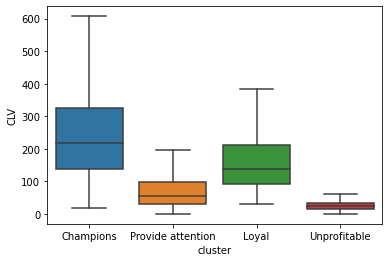

In [50]:
ax = sns.boxplot(x="cluster", y="CLV", data=final_df, showfliers=False)

<AxesSubplot:xlabel='frequency', ylabel='recency'>

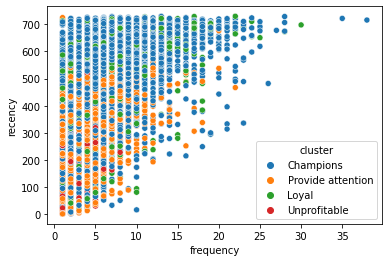

In [59]:
sns.scatterplot(data=final_df, x="frequency", y="recency", hue="cluster")

<AxesSubplot:xlabel='cluster', ylabel='predict_purch_30'>

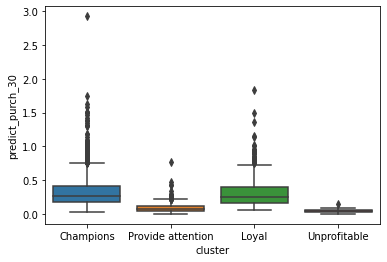

In [62]:
# Boxplot Purchase in the next 30 days 
sns.boxplot(x="cluster", y="predict_purch_30", data=final_df)

<AxesSubplot:xlabel='cluster', ylabel='predict_purch_90'>

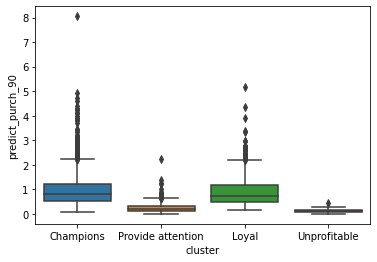

In [63]:
# Boxplot Purchase in the next 90 days 
sns.boxplot(x="cluster", y="predict_purch_90", data=final_df)

In [51]:
champions = final_df[final_df['cluster'] == 'Champions']
attention = final_df[final_df['cluster'] == 'Provide attention']
loyal = final_df[final_df['cluster'] == 'Loyal']
unprofitable = final_df[final_df['cluster'] == 'Unprofitable']

In [64]:
champions.describe()

,CLV,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,exp_avg_rev,avg_rev,error_rev
count,"4,369.000","4,369.000","4,369.000","4,369.000","4,369.000","4,369.000","4,369.000","4,369.000","4,369.000","4,369.000","4,369.000","4,369.000"
mean,254.493,6.214,453.431,516.826,83.835,0.104,0.311,0.617,0.918,81.725,83.835,-2.110
std,172.826,4.827,208.854,204.148,58.910,0.065,0.194,0.382,0.565,41.204,58.910,20.527
min,18.236,1.000,1.000,6.000,6.763,0.008,0.023,0.046,0.068,28.171,6.763,-377.700
25%,138.211,2.000,311.000,370.000,48.548,0.058,0.174,0.345,0.514,54.958,48.548,-3.098
50%,219.087,5.000,520.000,586.000,67.501,0.090,0.268,0.532,0.791,69.710,67.501,1.353
75%,326.305,9.000,624.000,692.000,100.415,0.136,0.407,0.806,1.199,95.647,100.415,4.267
max,"2,429.575",38.000,730.000,733.000,862.203,1.008,2.925,5.591,8.052,484.503,862.203,35.350


In [65]:
attention.describe()

,CLV,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,exp_avg_rev,avg_rev,error_rev
count,"2,866.000","2,866.000","2,866.000","2,866.000","2,866.000","2,866.000","2,866.000","2,866.000","2,866.000","2,866.000","2,866.000","2,866.000"
mean,75.665,3.139,227.876,588.766,88.109,0.027,0.081,0.162,0.241,85.232,88.109,-2.877
std,71.249,2.679,162.278,134.709,78.789,0.019,0.057,0.113,0.168,51.645,78.789,29.461
min,0.004,1.000,1.000,24.000,3.373,0.000,0.000,0.000,0.000,19.513,3.373,-576.399
25%,31.615,1.000,77.000,508.000,43.197,0.013,0.039,0.078,0.116,56.128,43.197,-6.378
50%,56.503,2.000,217.000,638.000,67.763,0.023,0.070,0.140,0.208,71.649,67.763,2.537
75%,97.184,4.000,367.000,699.000,105.631,0.037,0.111,0.221,0.330,98.113,105.631,10.089
max,"1,152.682",22.000,725.000,733.000,"1,891.059",0.256,0.765,1.516,2.256,"1,314.661","1,891.059",36.986


In [66]:
loyal.describe()

,CLV,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,exp_avg_rev,avg_rev,error_rev
count,778.000,778.000,778.000,778.000,778.000,778.000,778.000,778.000,778.000,778.000,778.000,778.000
mean,158.881,5.496,405.167,469.784,46.205,0.103,0.306,0.607,0.902,53.692,46.205,7.487
std,92.442,4.839,220.946,219.960,31.143,0.069,0.205,0.405,0.598,21.723,31.143,12.722
min,29.166,1.000,1.000,6.000,2.864,0.019,0.057,0.113,0.169,21.587,2.864,-126.323
25%,91.051,2.000,219.000,276.750,28.154,0.055,0.164,0.327,0.487,39.887,28.154,2.591
50%,138.245,4.000,455.500,518.500,40.165,0.083,0.249,0.494,0.734,49.454,40.165,5.437
75%,211.521,8.000,596.500,669.000,55.180,0.133,0.398,0.788,1.171,62.056,55.180,12.126
max,892.275,30.000,730.000,733.000,341.593,0.622,1.826,3.546,5.175,215.270,341.593,37.232


In [67]:
unprofitable.describe()

,CLV,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,exp_avg_rev,avg_rev,error_rev
count,337.000,337.000,337.000,337.000,337.000,337.000,337.000,337.000,337.000,337.000,337.000,337.000
mean,27.332,1.997,115.199,615.994,52.283,0.013,0.038,0.076,0.113,62.535,52.283,10.252
std,19.641,1.647,104.404,100.384,42.841,0.007,0.020,0.041,0.061,24.837,42.841,19.437
min,0.018,1.000,1.000,360.000,2.695,0.000,0.000,0.000,0.000,25.174,2.695,-125.030
25%,15.217,1.000,28.000,559.000,25.390,0.008,0.023,0.046,0.069,46.495,25.390,3.842
50%,24.729,1.000,84.000,647.000,40.627,0.013,0.038,0.076,0.114,56.110,40.627,12.416
75%,34.808,2.000,190.000,698.000,66.758,0.017,0.052,0.104,0.155,71.888,66.758,22.263
max,131.476,10.000,529.000,733.000,338.915,0.048,0.144,0.287,0.428,213.885,338.915,37.314


In [52]:
champions.boxplot

,customer_id,CLV,frequency,recency,T,monetary_value,predict_purch_10,predict_purch_30,predict_purch_60,predict_purch_90,exp_avg_rev,avg_rev,error_rev,cluster
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,256.848,9.000,618.000,635.000,59.874,0.129,0.384,0.763,1.136,61.763,59.874,1.889,Champions
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,258.278,6.000,726.000,733.000,103.910,0.078,0.233,0.464,0.692,100.686,103.910,-3.223,Champions
2,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,177.433,5.000,670.000,711.000,80.386,0.067,0.200,0.399,0.595,80.321,80.386,-0.065,Champions
3,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,76.587,1.000,249.000,312.000,42.339,0.039,0.115,0.229,0.342,60.510,42.339,18.172,Champions
4,0000b2f1829e23b24feec422ef13df3ccedaedc85368e6...,351.733,10.000,677.000,701.000,83.895,0.130,0.388,0.770,1.147,83.560,83.895,-0.335,Champions
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8342,0584f4fe53227034c3d36ed4966f927cf2f093411343c5...,179.805,13.000,605.000,627.000,26.965,0.184,0.549,1.089,1.621,30.517,26.965,3.552,Champions
8345,058551aae22c37412da14b7982ac1327ec5e85ddf6413e...,132.492,3.000,276.000,417.000,62.113,0.061,0.184,0.365,0.544,66.352,62.113,4.239,Champions
8346,0585761bf583cc8468a107690940cfc34e685cb75c6b0c...,536.372,7.000,594.000,642.000,178.426,0.099,0.295,0.586,0.874,166.840,178.426,-11.586,Champions
8348,0585b160249bbded354f06a87b8a7df1105025e876bf22...,87.440,2.000,8.000,159.000,33.017,0.059,0.175,0.346,0.513,47.961,33.017,14.944,Champions
